In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from mamba import Mamba, MambaConfig
import argparse
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import random
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr


/home/luchinwei/anaconda3/envs/mambastock/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
save_dir = '0728_2330_value_pca_7/'
use_cuda = True
seed_num = random.randint(0, 999999)
patience = 100
epochs = 1000
# loss_fnc = F.smooth_l1_loss
# loss_fnc = None

lr = 0.0005
wd = 1e-5
hidden = 70
layer = 20
n_test = 350
ts_code = 2330
risk_free = 0.017

In [3]:
def evaluation_metric(y_test,y_hat):
    MSE = mean_squared_error(y_test, y_hat)
    RMSE = MSE**0.5
    MAE = mean_absolute_error(y_test,y_hat)
    R2 = r2_score(y_test,y_hat)
    print('%.4f %.4f %.4f %.4f' % (MSE,RMSE,MAE,R2))

def set_seed(seed,cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed(seed)

def dateinf(series, n_test):
    lt = len(series)
    print('Training start',series[0])
    print('Training end',series[lt-n_test-1])
    print('Testing start',series[lt-n_test])
    print('Testing end',series[lt-1])

set_seed(seed_num,use_cuda)


class LogCoshLoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, pred, target):
        loss = torch.log(torch.cosh(pred - target))
        return torch.mean(loss)

class CharbonnierLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps
    def forward(self, pred, target):
        diff = pred - target
        loss = torch.sqrt(diff**2 + self.eps**2)
        return torch.mean(loss)

class QuantileLoss(nn.Module):
    def __init__(self, q=0.5):
        super().__init__()
        self.q = q
    def forward(self, pred, target):
        e = target - pred
        return torch.mean(torch.max(self.q * e, (self.q - 1) * e))



class HybridLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.logcosh = LogCoshLoss()
    def forward(self, pred, target):
        return 0.4 * self.logcosh(pred, target) + 0.6 * F.mse_loss(pred, target)

# 結合 RMSE + RIC 方向性損失
def make_composite_loss():
    def loss_fn(pred, target):
        mse = F.mse_loss(pred, target)
        ric = spearmanr(pred.detach().cpu().numpy(), target.detach().cpu().numpy())[0]
        penalty = torch.tensor(1 - ric**2)  # 強化方向誤差
        return mse + 0.5 * penalty
    return loss_fn



class TopKPairwiseHingeLoss(nn.Module):
    def __init__(self, k=10, margin=1.0):
        super().__init__()
        self.k = k
        self.margin = margin

    def forward(self, scores, labels):
        """
        scores: [N] tensor of predicted values
        labels: [N] tensor of true values (for sorting reference)
        """
        # 取得 top-K 與 bottom-K 的 index
        topk_idx = torch.topk(labels, self.k).indices
        bottomk_idx = torch.topk(-labels, self.k).indices

        # 預測分數差異
        score_top = scores[topk_idx]
        score_bottom = scores[bottomk_idx]

        # 計算 pairwise hinge loss
        # 損失 = margin - (top - bottom)，期望 top > bottom
        diff = score_top.unsqueeze(1) - score_bottom.unsqueeze(0)
        hinge = F.relu(self.margin - diff)

        return hinge.mean()




# loss_fnc = LogCoshLoss()
# loss_fnc = CharbonnierLoss()
# loss_fnc = QuantileLoss()

loss_fnc = HybridLoss()
# loss_fnc = make_composite_loss()

# loss_fnc = TopKPairwiseHingeLoss(k=10, margin=1.0)

In [4]:
class Net(nn.Module):
    def __init__(self, in_dim, out_dim, use_pca=False, pca_dim=None, pca_components=None):
        super().__init__()
        self.use_pca = use_pca

        if self.use_pca:
            assert pca_dim is not None and pca_components is not None, "需提供 pca_dim 和 pca_components"
            self.pca_layer = nn.Linear(in_dim, pca_dim, bias=False)
            self.pca_layer.weight.data = torch.tensor(pca_components, dtype=torch.float32)
            self.pca_layer.weight.requires_grad = False  # 若不希望訓練 PCA 權重
            in_dim = pca_dim  # 更新模型輸入維度

        self.config = MambaConfig(d_model=hidden, n_layers=layer)
        self.mamba = nn.Sequential(
            nn.Linear(in_dim, hidden),
            Mamba(self.config),
            nn.Linear(hidden, out_dim),
            # nn.Tanh()
        )

    def forward(self, x):
        if self.use_pca:
            x = self.pca_layer(x)
        x = self.mamba(x)
        return x.flatten()


def spearman_metric(y_true, y_pred):
    return spearmanr(y_true.cpu().numpy(), y_pred.cpu().numpy())[0]


def PredictWithData(trainX, trainy, testX, save_dir,use_pca=False, pca_dim=None, pca_components=None, val_ratio=0.2, patience=patience, loss_fnc=None):
    clf = Net(in_dim=trainX.shape[1], out_dim=1, use_pca=use_pca, pca_dim=pca_dim, pca_components=pca_components)
    

    
    opt = torch.optim.Adam(clf.parameters(),lr=lr,weight_decay=wd)
    
    val_size = int(len(trainX) * val_ratio)
    
    X_train = trainX[:-val_size]
    y_train = trainy[:-val_size]
    X_val = trainX[-val_size:]
    y_val = trainy[-val_size:]
    
    xt = torch.from_numpy(X_train).float().unsqueeze(1)  # → (batch_size, 1, feature_dim)
    xv = torch.from_numpy(X_val).float().unsqueeze(1)
    x_test = torch.from_numpy(testX).float().unsqueeze(1)

    yt = torch.from_numpy(y_train).float()
    yv = torch.from_numpy(y_val).float()
    

    
    if loss_fnc is None:
        loss_fnc = F.mse_loss
    
    best_r2 = -float('inf')
    best_rmse = float('inf')
    best_state_dict = None
    best_epoch = 0

    for e in range(epochs):
        clf.train()
        pred = clf(xt)
        loss = loss_fnc(pred, yt)

        opt.zero_grad()
        loss.backward()
        opt.step()

        clf.eval()
        with torch.no_grad():
            val_pred = clf(xv)
            val_loss = loss_fnc(val_pred, yv)

            val_pred_np = val_pred.cpu().numpy().flatten()
            r2 = r2_score(y_val, val_pred_np)
            spearman = spearman_metric(yv, val_pred)

        print(f'Epoch {e:03d} | Val R²: {r2:.4f} | Spearman: {spearman:.4f}')

        if r2 > best_r2:
            best_r2 = r2
            best_epoch = e
            best_state_dict = clf.state_dict()
            best_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")      
        elif e - best_epoch >= patience:
            print(f"Early stopping triggered at epoch {e}")
            break
        
        # print(f'Epoch {e:03d} | Val RMSE: {RMSE:.4f}')

        # if RMSE < best_rmse:
        #     best_rmse = RMSE
        #     best_epoch = e
        #     best_state_dict = clf.state_dict()
        #     best_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")      
        # elif e - best_epoch >= patience:
        #     print(f"Early stopping triggered at epoch {e}")
        #     break

    best_model_path = f"{save_dir}model_{best_timestamp}.pth"
    torch.save(best_state_dict, best_model_path)
    print(f"Best model saved to: {best_model_path}")
    
    
    val_true = y_val
    val_pred_np = val_pred.cpu().numpy().flatten() if use_cuda else val_pred.numpy().flatten()

    MSE = mean_squared_error(val_true, val_pred_np)
    RMSE = MSE ** 0.5
    MAE = mean_absolute_error(val_true, val_pred_np)
    R2 = r2_score(val_true, val_pred_np)

    # 儲存評估指標
    # 儲存評估指標
    # log_path = f"{save_dir}/evaluation_log.txt"
    # with open(log_path, 'a') as f:
    #     f.write(f"Model: model_{best_timestamp}.pth\n")
    #     f.write(f"  MSE: {MSE:.4f} | RMSE: {RMSE:.4f} | MAE: {MAE:.4f} | R²: {R2:.4f}\n")
    #     f.write("-" * 60 + "\n")
    log_path = f"{save_dir}/evaluation_log.txt"
    with open(log_path, 'a') as f:
        f.write(f"Model: model_{best_timestamp}.pth\n")
        f.write(f"  MSE: {MSE:.4f} | RMSE: {RMSE:.4f} | MAE: {MAE:.4f} | R²: {R2:.4f} | Spearman: {spearman:.4f}\n")
        f.write("-" * 60 + "\n")

    
    clf.load_state_dict(best_state_dict)
    clf.eval()
    mat = clf(x_test)
    if use_cuda: mat = mat.cpu()
    yhat = mat.detach().numpy().flatten()
    return yhat

Epoch 000 | Val R²: -445.4630 | Spearman: 0.0274
Epoch 001 | Val R²: -180.4983 | Spearman: 0.0273
Epoch 002 | Val R²: -37.6481 | Spearman: 0.0272
Epoch 003 | Val R²: -0.2650 | Spearman: 0.0274
Epoch 004 | Val R²: -36.6500 | Spearman: 0.0275
Epoch 005 | Val R²: -103.4548 | Spearman: 0.0281
Epoch 006 | Val R²: -160.5898 | Spearman: 0.0282
Epoch 007 | Val R²: -185.8226 | Spearman: 0.0278
Epoch 008 | Val R²: -176.4564 | Spearman: 0.0284
Epoch 009 | Val R²: -141.9067 | Spearman: 0.0306
Epoch 010 | Val R²: -95.9229 | Spearman: 0.0340
Epoch 011 | Val R²: -51.5906 | Spearman: 0.0039
Epoch 012 | Val R²: -18.6175 | Spearman: -0.0142
Epoch 013 | Val R²: -2.0003 | Spearman: -0.0195
Epoch 014 | Val R²: -1.7026 | Spearman: -0.0202
Epoch 015 | Val R²: -13.3813 | Spearman: -0.0211
Epoch 016 | Val R²: -30.1595 | Spearman: -0.0218
Epoch 017 | Val R²: -45.0111 | Spearman: -0.0222
Epoch 018 | Val R²: -52.9038 | Spearman: -0.0222
Epoch 019 | Val R²: -51.9358 | Spearman: -0.0218
Epoch 020 | Val R²: -43.2569

/home/luchinwei/anaconda3/envs/mambastock/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


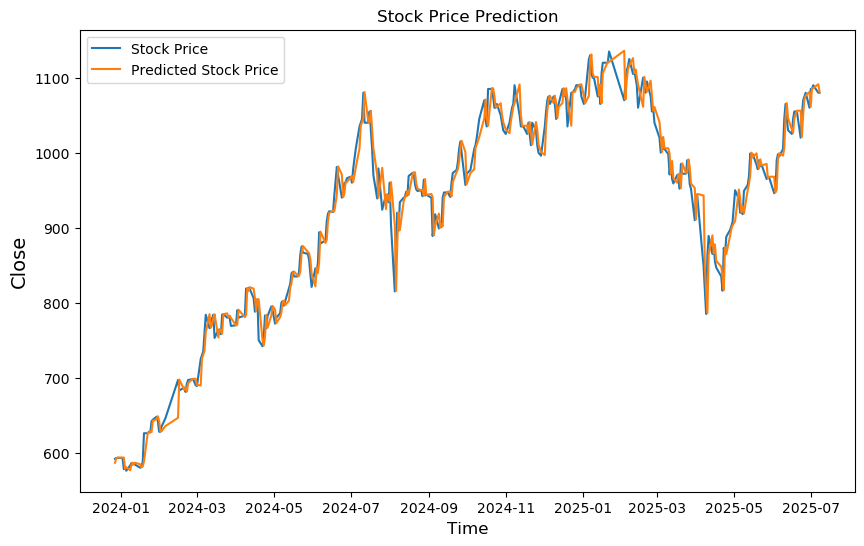

In [5]:
data = pd.read_csv(str(ts_code)+"_value"+'.csv')
data['trade_date'] = pd.to_datetime(data['trade_date'], format='%Y/%m/%d')

# 拆離 label 欄位
close = data.pop('close_TW').values
ratechg = data['close_TW_roc'].values
data.drop(columns=['close_TW_roc'], inplace=True)

# 擷取有效特徵欄位區段
dat = data.iloc[:, 4:].values

# scaler = StandardScaler()
# dat_scaled = scaler.fit_transform(dat)

use_pca = False
pca_dim = 25


if use_pca:
    pca = PCA(n_components=pca_dim)
    pca.fit(dat)

    pca_components = pca.components_[:pca_dim]
    dat_pca = dat @ pca_components.T
else:
    dat_pca = dat 
    
trainX, testX = dat_pca[:-n_test], dat_pca[-n_test:]
trainy = ratechg[:-n_test]
trainy = pd.Series(trainy).ewm(span=5).mean().values

predictions = PredictWithData(trainX, trainy, testX, save_dir, loss_fnc=loss_fnc)
time = data['trade_date'][-n_test:]
data1 = close[-n_test:]
finalpredicted_stock_price = []
pred = close[-n_test-1]
for i in range(n_test):
    pred = close[-n_test-1+i]*(1+predictions[i])
    finalpredicted_stock_price.append(pred)
    
    
dateinf(data['trade_date'],n_test)
print('MSE RMSE MAE R2')
evaluation_metric(data1, finalpredicted_stock_price)
plt.figure(figsize=(10, 6))
plt.plot(time, data1, label='Stock Price')
plt.plot(time, finalpredicted_stock_price, label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()